# Abductive Event Reasoning (AER) Dataset Analysis

This notebook provides a comprehensive analysis of the SemEval 2026 Task 12 dataset for Abductive Event Reasoning.

## 1. Imports and Setup

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.manifold import TSNE
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Loading Functions

In [2]:
def load_jsonl(file_path):
    """Reads a JSONL file and returns a list of dictionaries."""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data

def load_json(file_path):
    """Reads a JSON file and returns the data."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

print("Data loading functions defined!")

Data loading functions defined!


## 3. Load Dataset

Choose which dataset to analyze: 'sample_data', 'train_data', or 'dev_data'

In [3]:
# Change this to analyze different datasets: 'sample_data', 'train_data', or 'dev_data'
DATASET = 'sample_data'

questions_path = f'{DATASET}/questions.jsonl'
docs_path = f'{DATASET}/docs.json'

# Load data
try:
    questions_data = load_jsonl(questions_path)
    docs_data = load_json(docs_path)
    
    df_questions = pd.DataFrame(questions_data)
    df_docs = pd.DataFrame(docs_data)
    
    print(f"✓ Loaded {len(df_questions)} questions from {DATASET}")
    print(f"✓ Loaded {len(df_docs)} document sets from {DATASET}")
    print(f"✓ Unique topics: {df_questions['topic_id'].nunique()}")
    
except FileNotFoundError as e:
    print(f"Error: Files not found - {e}")
    print("Please ensure the paths are correct.")

✓ Loaded 200 questions from sample_data
✓ Loaded 10 document sets from sample_data
✓ Unique topics: 10


## 4. Basic Data Inspection

In [4]:
# Display first few rows of questions
print("=" * 80)
print("QUESTIONS DATAFRAME")
print("=" * 80)
display(df_questions.head())

print("\n" + "=" * 80)
print("QUESTIONS SCHEMA")
print("=" * 80)
print(df_questions.info())

QUESTIONS DATAFRAME


,topic_id,uuid,target_event,option_A,option_B,option_C,option_D,golden_answer
0,4,02777771-93de-450d-9a16-b08b25f2e2c8,Videos of the assassination circulated on soci...,The shooter used a handmade gun.,"Security arrested the suspected gunman, Tetsuy...",Shinzo Abe became the deputy chief cabinet sec...,A man fired twice at Shinzo Abe.,D
1,3,42359370-0cc8-475d-bb3e-90623f86e5df,Trump was impeached for a second time on Janua...,Pipe bombs were reported at the Republican Nat...,Trump addressed the crowd.,None of the others are correct causes.,"Trump supporters protested in Washington, D.C.",C
2,7,a82409ed-dddc-4779-81a7-83a872685c10,The impeachment motion against President Yoon ...,Opposition legislators filed an impeachment mo...,None of the others are correct causes.,Baek Jae Gil performed his protest anthem for ...,President Yoon Suk Yeol declared martial law o...,B
3,4,646e4473-68a8-4b6a-8e5a-c788c717f856,Social media companies removed harmful content.,Shinzo Abe became the deputy chief cabinet sec...,Yoshihide Suga succeeded Shinzo Abe in Septemb...,Shinzo Abe offered to host a peace summit in 2...,Videos of the assassination circulated on soci...,D
4,5,4778d001-0f67-4d20-bf62-7082caa1619b,"On November 10, Musk stated bankruptcy was pos...",Twitter sued Elon Musk to force the acquisition.,Elon Musk changed his profile to ‘Chief Twit’.,None of the others are correct causes.,Elon Musk signed a deal to acquire Twitter in ...,C



QUESTIONS SCHEMA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   topic_id       200 non-null    int64 
 1   uuid           200 non-null    object
 2   target_event   200 non-null    object
 3   option_A       200 non-null    object
 4   option_B       200 non-null    object
 5   option_C       200 non-null    object
 6   option_D       200 non-null    object
 7   golden_answer  200 non-null    object
dtypes: int64(1), object(7)
memory usage: 12.6+ KB
None


In [30]:
# Display structure of Docs
print("=" * 80)
print("DOCS DATAFRAME")
print("=" * 80)
display(df_docs.head(5))

print("\n" + "=" * 80)
print("SAMPLE TOPIC AND DOCUMENTS")
print("=" * 80)
if len(df_docs) > 0:
    sample_topic = df_docs.iloc[0]
    print(f"Topic ID: {sample_topic['topic_id']}")
    print(f"Topic: {sample_topic['topic']}")
    print(f"Number of docs: {len(sample_topic['docs'])}")
    print("\nFirst document:")
    if len(sample_topic['docs']) > 0:
        first_doc = sample_topic['docs'][0]
        for key, value in first_doc.items():
            if isinstance(value, str) and len(value) > 100:
                print(f"  {key}: {value[:100]}...")
            else:
                print(f"  {key}: {value}")

DOCS DATAFRAME


,topic_id,topic,docs
0,1,"UK holds Brexit referendum, decides to leave EU",[{'title': 'What next for EU-Poland ties after...
1,3,Trump supporters storm US Capitol,[{'title': 'US Government Designates Riot Game...
2,4,Former Japanese PM Shinzo Abe assassinated,[{'title': 'Violence Shadows Ecuador's Preside...
3,2,COVID-19 pandemic triggers global health crisis,[{'title': 'Seasonal Flu Shots Miss the Mark o...
4,5,"Elon Musk acquires Twitter, implements major r...",[{'title': 'Publicis Groupe Taps Captiv8 to Po...



SAMPLE TOPIC AND DOCUMENTS
Topic ID: 1
Topic: UK holds Brexit referendum, decides to leave EU
Number of docs: 17

First document:
  title: What next for EU-Poland ties after Nawrocki's election win?
  link: https://www.dw.com/en/what-next-for-eu-poland-ties-after-nawrockis-election-win/a-72778503
  snippet: Newly elected Polish President Karol Nawrocki is known as an EU skeptic. How can he sway Poland's EU...
  source: DW
  imageUrl: data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBwgHBgkIBwgKCgkLDRYPDQwMDRsUFRAWIB0iIiAdH...
  content: Newly elected Polish President Karol Nawrocki is known as an EU skeptic. How can he sway Poland's EU...
  uuid: eab5abb6-85d8-4920-844b-f3d2ad3ea87d


In [6]:
# Check for missing values
print("=" * 80)
print("MISSING VALUES ANALYSIS")
print("=" * 80)
print("\nQuestions DataFrame:")
missing_questions = df_questions.isnull().sum()
if missing_questions.sum() == 0:
    print("  No missing values found!")
else:
    print(missing_questions[missing_questions > 0])

print("\nDocs DataFrame:")
missing_docs = df_docs.isnull().sum()
if missing_docs.sum() == 0:
    print("  No missing values found!")
else:
    print(missing_docs[missing_docs > 0])

MISSING VALUES ANALYSIS

Questions DataFrame:
  No missing values found!

Docs DataFrame:
  No missing values found!


## 5. Topic Distribution Analysis

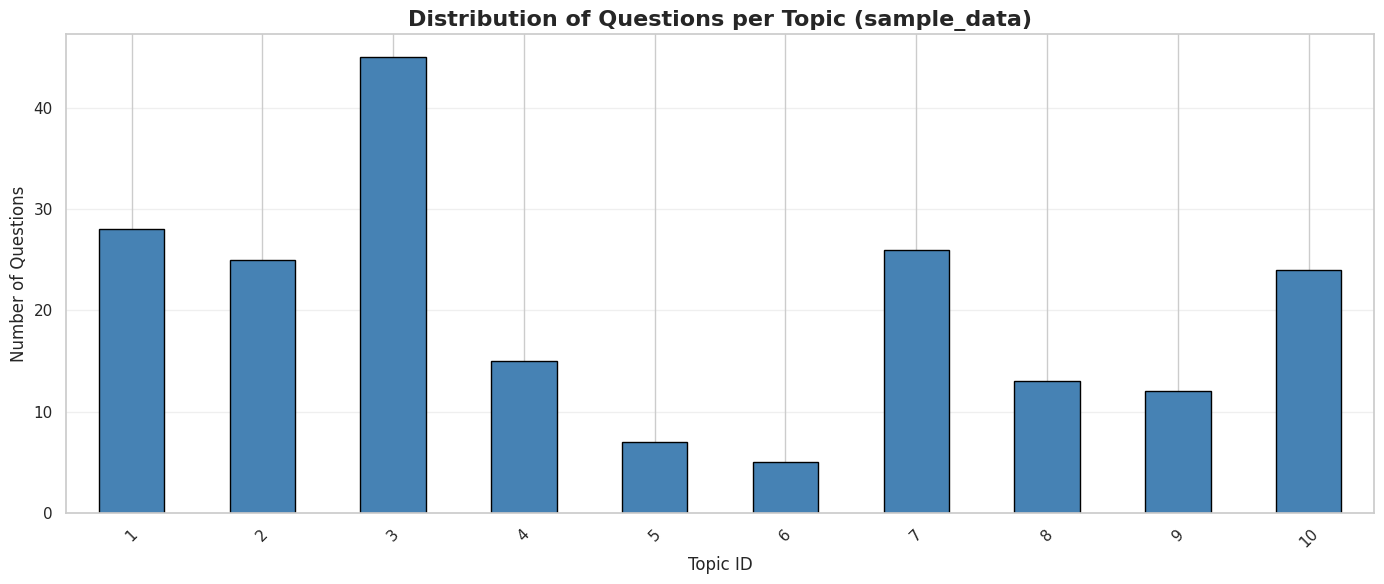


Statistics:
  Total topics: 10
  Mean questions per topic: 20.00
  Median questions per topic: 19.50
  Min questions: 5
  Max questions: 45


In [7]:
# Questions per topic
topic_counts = df_questions['topic_id'].value_counts().sort_index()

plt.figure(figsize=(14, 6))
topic_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title(f'Distribution of Questions per Topic ({DATASET})', fontsize=16, fontweight='bold')
plt.xlabel('Topic ID', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nStatistics:")
print(f"  Total topics: {len(topic_counts)}")
print(f"  Mean questions per topic: {topic_counts.mean():.2f}")
print(f"  Median questions per topic: {topic_counts.median():.2f}")
print(f"  Min questions: {topic_counts.min()}")
print(f"  Max questions: {topic_counts.max()}")

## 6. Answer Distribution Analysis

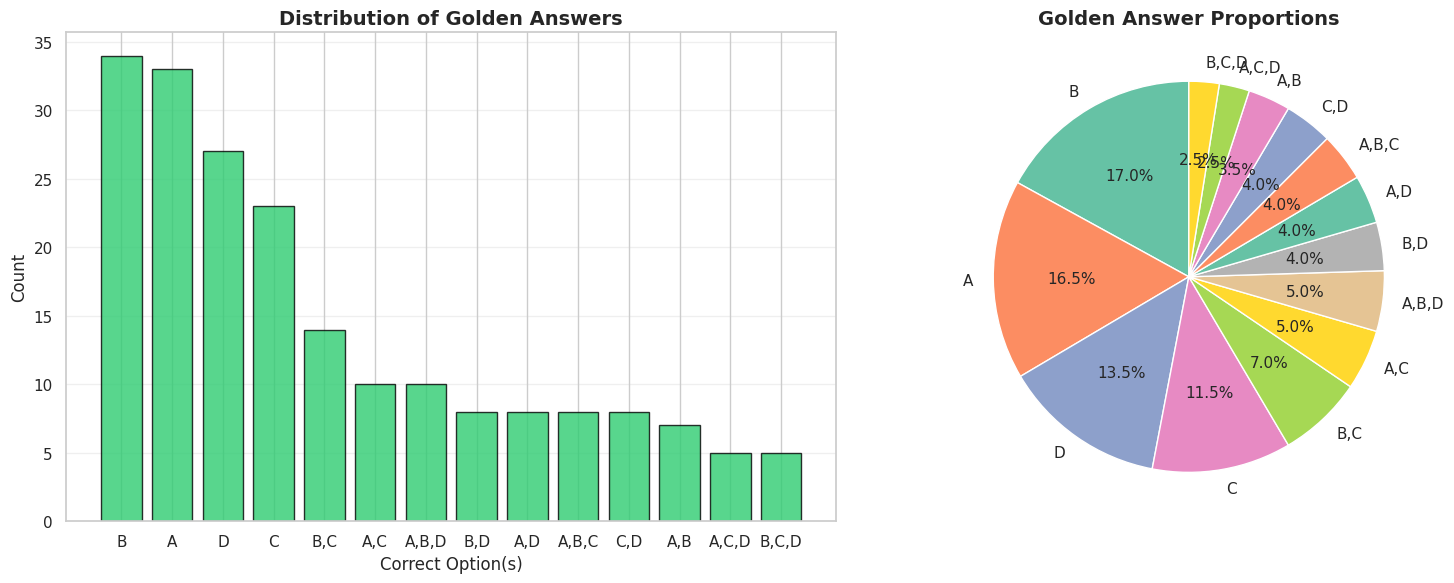


Answer Distribution:
  B:   34 (17.00%)
  A:   33 (16.50%)
  D:   27 (13.50%)
  C:   23 (11.50%)
  B,C:   14 ( 7.00%)
  A,C:   10 ( 5.00%)
  A,B,D:   10 ( 5.00%)
  B,D:    8 ( 4.00%)
  A,D:    8 ( 4.00%)
  A,B,C:    8 ( 4.00%)
  C,D:    8 ( 4.00%)
  A,B:    7 ( 3.50%)
  A,C,D:    5 ( 2.50%)
  B,C,D:    5 ( 2.50%)

Note: Answer 'C' appears 23 times (often 'None of the others are correct causes')


In [8]:
# Analyze the distribution of golden answers
answer_counts = df_questions['golden_answer'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
axes[0].bar(answer_counts.index, answer_counts.values, color='#2ecc71', edgecolor='black', alpha=0.8)
axes[0].set_title('Distribution of Golden Answers', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Correct Option(s)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
colors = sns.color_palette('Set2', len(answer_counts))
axes[1].pie(answer_counts.values, labels=answer_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 11})
axes[1].set_title('Golden Answer Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nAnswer Distribution:")
for ans, count in answer_counts.items():
    percentage = (count / len(df_questions)) * 100
    print(f"  {ans}: {count:4d} ({percentage:5.2f}%)")

# Check for "None of the others" pattern
none_c_count = df_questions[df_questions['golden_answer'] == 'C'].shape[0]
print(f"\nNote: Answer 'C' appears {none_c_count} times (often 'None of the others are correct causes')")

## 7. Text Length Analysis

In [9]:
# Calculate word counts for various text fields
df_questions['event_word_count'] = df_questions['target_event'].apply(lambda x: len(str(x).split()))
df_questions['option_A_len'] = df_questions['option_A'].apply(lambda x: len(str(x).split()))
df_questions['option_B_len'] = df_questions['option_B'].apply(lambda x: len(str(x).split()))
df_questions['option_C_len'] = df_questions['option_C'].apply(lambda x: len(str(x).split()))
df_questions['option_D_len'] = df_questions['option_D'].apply(lambda x: len(str(x).split()))
df_questions['avg_option_len'] = df_questions[['option_A_len', 'option_B_len', 'option_C_len', 'option_D_len']].mean(axis=1)

print("Text length features computed!")

Text length features computed!


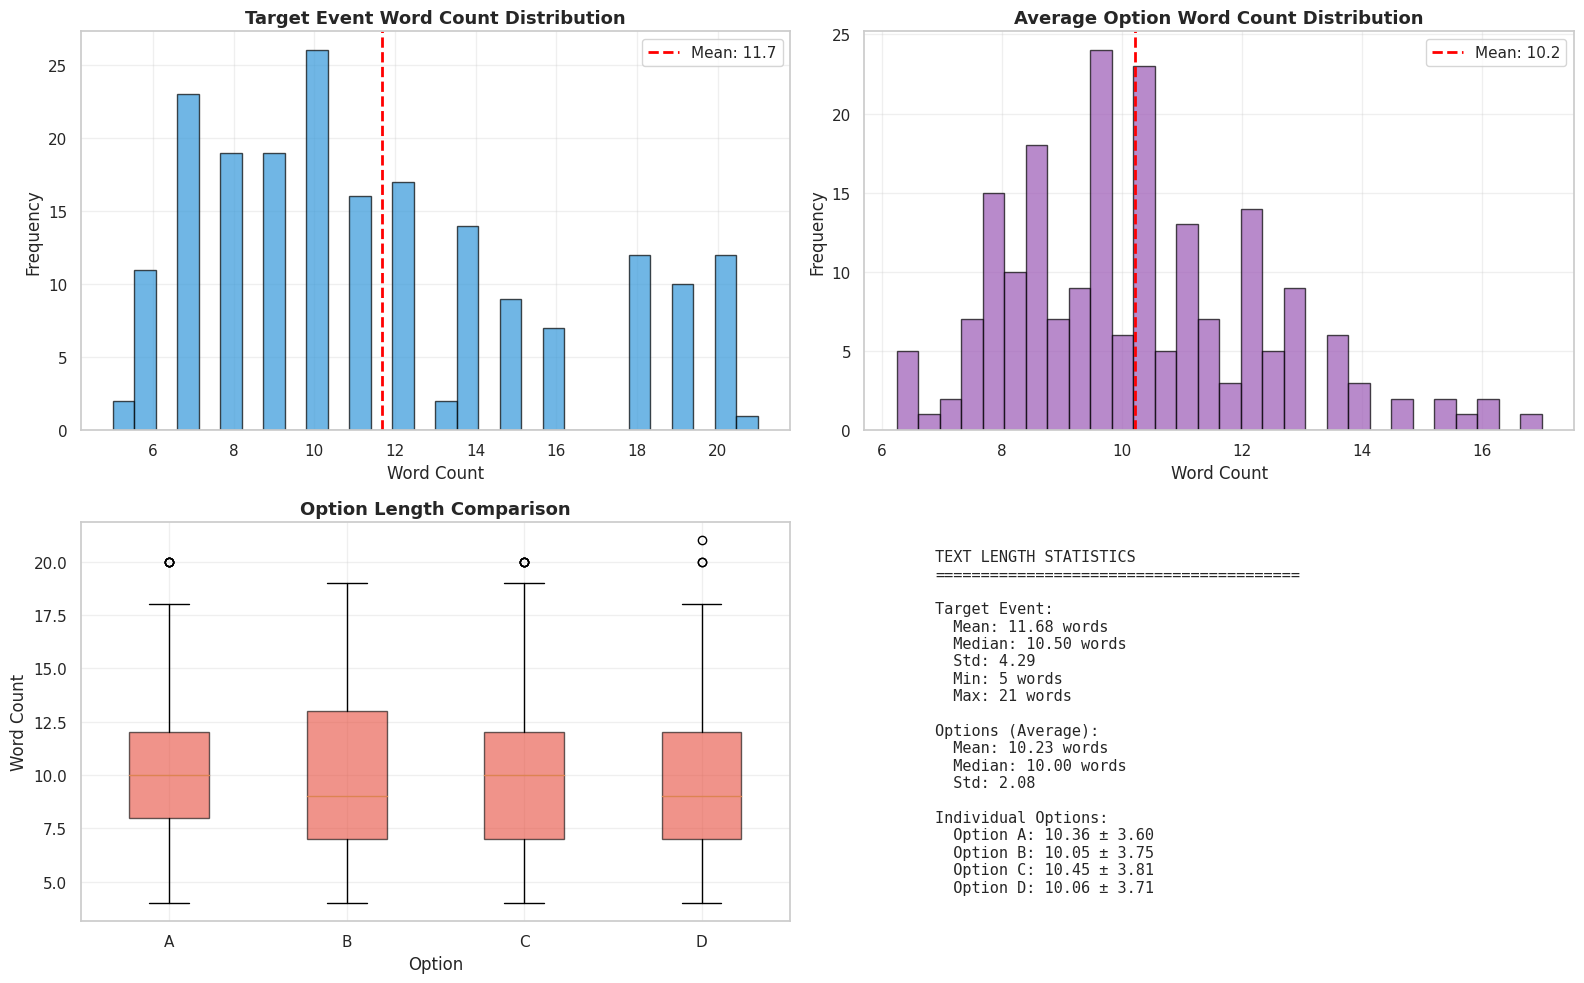

In [10]:
# Plot Event Description Lengths
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Target Event lengths
axes[0, 0].hist(df_questions['event_word_count'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_questions['event_word_count'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_questions["event_word_count"].mean():.1f}')
axes[0, 0].set_title('Target Event Word Count Distribution', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Word Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Average Option lengths
axes[0, 1].hist(df_questions['avg_option_len'], bins=30, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df_questions['avg_option_len'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df_questions["avg_option_len"].mean():.1f}')
axes[0, 1].set_title('Average Option Word Count Distribution', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Box plot comparison
option_data = df_questions[['option_A_len', 'option_B_len', 'option_C_len', 'option_D_len']]
axes[1, 0].boxplot([option_data['option_A_len'], option_data['option_B_len'], 
                     option_data['option_C_len'], option_data['option_D_len']], 
                    labels=['A', 'B', 'C', 'D'],
                    patch_artist=True,
                    boxprops=dict(facecolor='#e74c3c', alpha=0.6))
axes[1, 0].set_title('Option Length Comparison', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Option')
axes[1, 0].set_ylabel('Word Count')
axes[1, 0].grid(alpha=0.3)

# Summary statistics
axes[1, 1].axis('off')
summary_text = f"""
TEXT LENGTH STATISTICS
{'='*40}

Target Event:
  Mean: {df_questions['event_word_count'].mean():.2f} words
  Median: {df_questions['event_word_count'].median():.2f} words
  Std: {df_questions['event_word_count'].std():.2f}
  Min: {df_questions['event_word_count'].min()} words
  Max: {df_questions['event_word_count'].max()} words

Options (Average):
  Mean: {df_questions['avg_option_len'].mean():.2f} words
  Median: {df_questions['avg_option_len'].median():.2f} words
  Std: {df_questions['avg_option_len'].std():.2f}

Individual Options:
  Option A: {df_questions['option_A_len'].mean():.2f} ± {df_questions['option_A_len'].std():.2f}
  Option B: {df_questions['option_B_len'].mean():.2f} ± {df_questions['option_B_len'].std():.2f}
  Option C: {df_questions['option_C_len'].mean():.2f} ± {df_questions['option_C_len'].std():.2f}
  Option D: {df_questions['option_D_len'].mean():.2f} ± {df_questions['option_D_len'].std():.2f}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace', 
                verticalalignment='center')

plt.tight_layout()
plt.show()

## 8. Document Analysis

In [11]:
# Analyze document lengths and counts
all_doc_lengths = []
doc_counts_per_topic = []
doc_title_lengths = []
doc_snippet_lengths = []

for entry in docs_data:
    docs = entry.get('docs', [])
    doc_counts_per_topic.append(len(docs))
    
    for doc in docs:
        # Get snippet (this is typically the content field)
        snippet = doc.get('snippet', '')
        title = doc.get('title', '')
        
        if snippet:
            doc_snippet_lengths.append(len(snippet.split()))
        if title:
            doc_title_lengths.append(len(title.split()))
        
        # Combined content (title + snippet)
        combined = f"{title} {snippet}"
        all_doc_lengths.append(len(combined.split()))

print(f"Total documents across all topics: {len(all_doc_lengths)}")
print(f"Average docs per topic: {np.mean(doc_counts_per_topic):.2f}")
print(f"Average word count per document (title + snippet): {np.mean(all_doc_lengths):.2f}")

Total documents across all topics: 164
Average docs per topic: 16.40
Average word count per document (title + snippet): 32.88


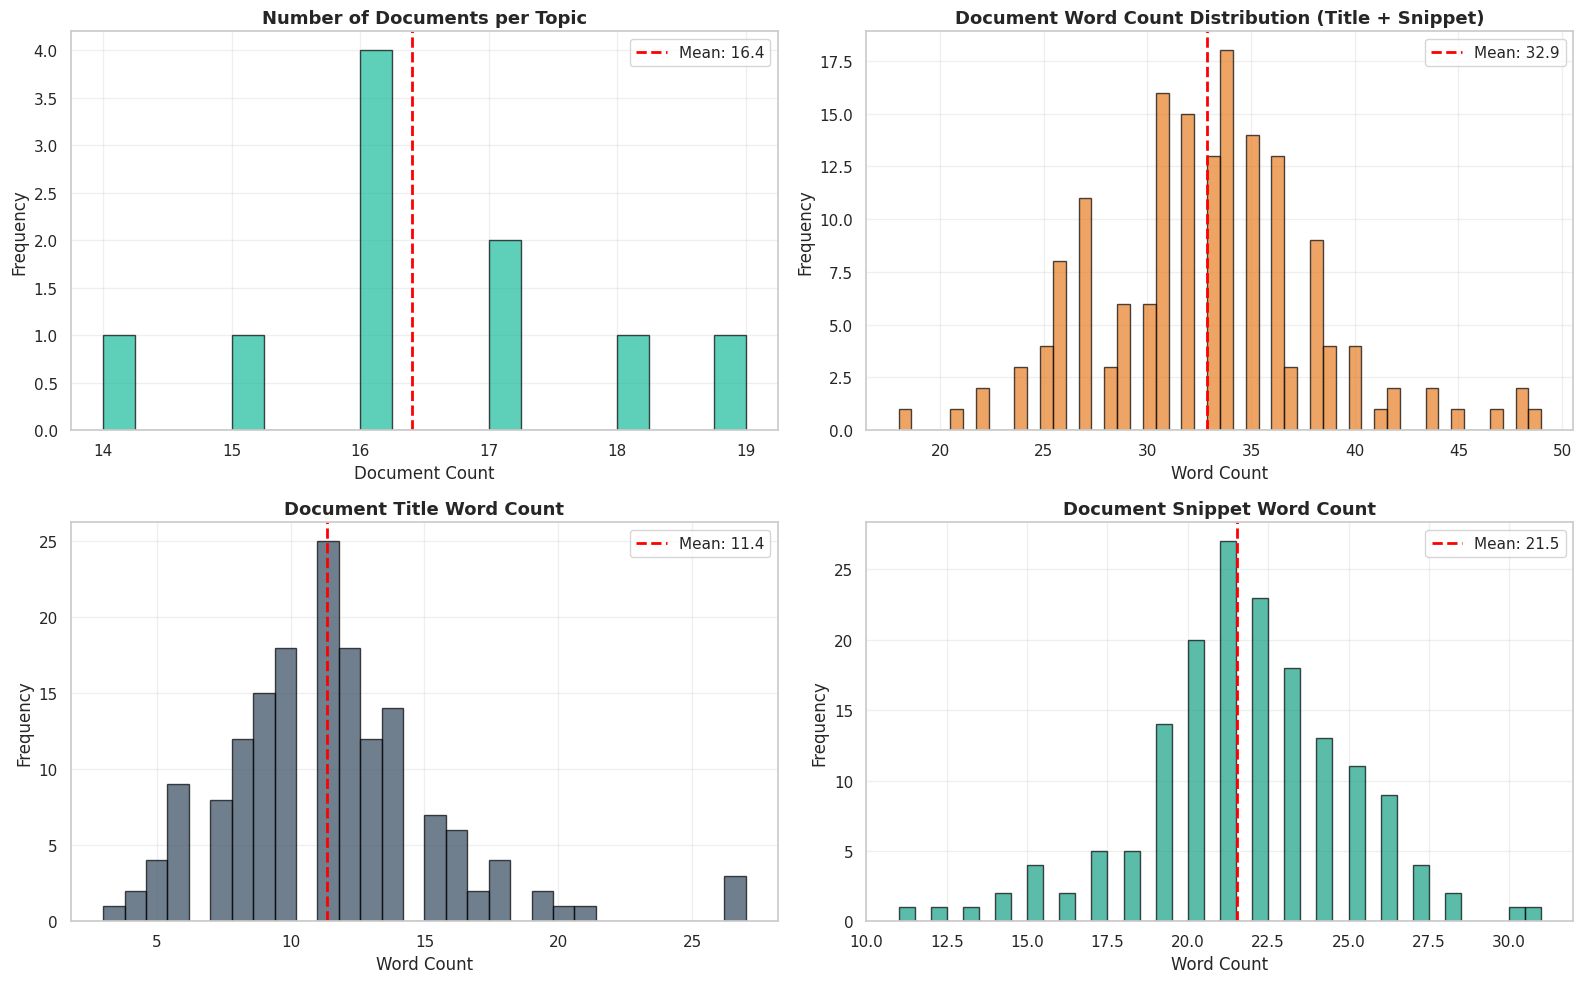


DOCUMENT STATISTICS
Documents per topic:
  Mean: 16.40
  Median: 16.00
  Min: 14
  Max: 19

Document content (title + snippet):
  Mean: 32.88 words
  Median: 33.00 words
  Std: 5.25


In [12]:
# Visualize document statistics
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Document count per topic
axes[0, 0].hist(doc_counts_per_topic, bins=20, color='#1abc9c', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.mean(doc_counts_per_topic), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {np.mean(doc_counts_per_topic):.1f}')
axes[0, 0].set_title('Number of Documents per Topic', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Document Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Document content length
axes[0, 1].hist(all_doc_lengths, bins=50, color='#e67e22', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(np.mean(all_doc_lengths), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(all_doc_lengths):.1f}')
axes[0, 1].set_title('Document Word Count Distribution (Title + Snippet)', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Title lengths
axes[1, 0].hist(doc_title_lengths, bins=30, color='#34495e', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(np.mean(doc_title_lengths), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(doc_title_lengths):.1f}')
axes[1, 0].set_title('Document Title Word Count', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Snippet lengths
axes[1, 1].hist(doc_snippet_lengths, bins=40, color='#16a085', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(np.mean(doc_snippet_lengths), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(doc_snippet_lengths):.1f}')
axes[1, 1].set_title('Document Snippet Word Count', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDOCUMENT STATISTICS")
print("=" * 50)
print(f"Documents per topic:")
print(f"  Mean: {np.mean(doc_counts_per_topic):.2f}")
print(f"  Median: {np.median(doc_counts_per_topic):.2f}")
print(f"  Min: {np.min(doc_counts_per_topic)}")
print(f"  Max: {np.max(doc_counts_per_topic)}")
print(f"\nDocument content (title + snippet):")
print(f"  Mean: {np.mean(all_doc_lengths):.2f} words")
print(f"  Median: {np.median(all_doc_lengths):.2f} words")
print(f"  Std: {np.std(all_doc_lengths):.2f}")

## 9. TF-IDF Similarity Analysis

This section analyzes the lexical similarity between target events and their context documents using TF-IDF vectors. High similarity might indicate that simple keyword matching could solve the task, while low similarity suggests deeper reasoning is required.

In [13]:
# Create a mapping from topic_id to combined document text
topic_doc_map = {}
for entry in docs_data:
    t_id = entry['topic_id']
    # Combine titles and snippets for better context
    full_text = " ".join([
        d.get('title', '') + " " + d.get('snippet', '') 
        for d in entry.get('docs', [])
    ])
    topic_doc_map[t_id] = full_text

print(f"Created document map for {len(topic_doc_map)} topics")

Created document map for 10 topics


In [14]:
# Calculate TF-IDF similarity between target events and context documents
try:
    from tqdm.auto import tqdm
    has_tqdm = True
except ImportError:
    has_tqdm = False
    print("tqdm not installed. Progress bar will not be shown.")

similarities = []
event_to_options_sim = []
correct_option_sim = []

print("Computing TF-IDF similarities...")
iterator = tqdm(df_questions.iterrows(), total=len(df_questions)) if has_tqdm else df_questions.iterrows()

for index, row in iterator:
    t_id = row['topic_id']
    
    if t_id in topic_doc_map:
        context = topic_doc_map[t_id]
        event = row['target_event']
        
        # Create corpus for this specific instance
        corpus = [event, context]
        
        # TF-IDF Vectorization
        vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
        tfidf_matrix = vectorizer.fit_transform(corpus)
        
        # Calculate cosine similarity between Event and Context
        sim_score = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        similarities.append(sim_score)
        
        # Calculate similarity between event and each option
        options_text = [
            row['option_A'], 
            row['option_B'], 
            row['option_C'], 
            row['option_D']
        ]
        event_options_corpus = [event] + options_text
        try:
            vec2 = TfidfVectorizer(stop_words='english')
            tfidf_eo = vec2.fit_transform(event_options_corpus)
            option_sims = cosine_similarity(tfidf_eo[0:1], tfidf_eo[1:])[0]
            event_to_options_sim.append(np.mean(option_sims))
            
            # Get similarity with correct answer
            answer_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
            golden = row['golden_answer']
            if golden in answer_map:
                correct_option_sim.append(option_sims[answer_map[golden]])
            else:
                correct_option_sim.append(np.nan)
        except:
            event_to_options_sim.append(0)
            correct_option_sim.append(np.nan)
    else:
        similarities.append(0)
        event_to_options_sim.append(0)
        correct_option_sim.append(np.nan)

df_questions['context_similarity'] = similarities
df_questions['event_options_similarity'] = event_to_options_sim
df_questions['correct_option_similarity'] = correct_option_sim

print("Similarity computation completed!")

Computing TF-IDF similarities...


  0%|          | 0/200 [00:00<?, ?it/s]

Similarity computation completed!


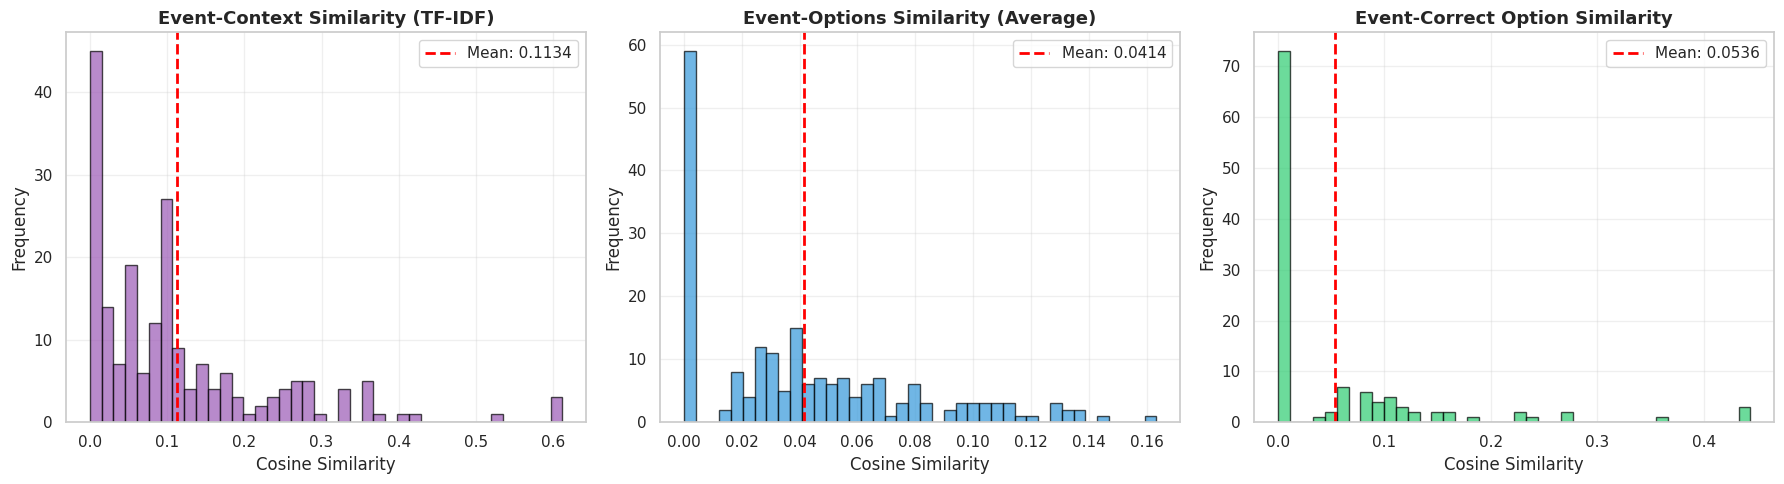


SIMILARITY STATISTICS
Event-Context Similarity:
  Mean: 0.1134
  Median: 0.0878
  Std: 0.1209

Event-Options Similarity (Average):
  Mean: 0.0414
  Median: 0.0364

Event-Correct Option Similarity:
  Mean: 0.0536
  Median: 0.0000

Interpretation:
  Low similarity suggests the task requires deep reasoning beyond keyword matching.


In [15]:
# Visualize similarity distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Event-Context Similarity
axes[0].hist(df_questions['context_similarity'], bins=40, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[0].axvline(df_questions['context_similarity'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df_questions["context_similarity"].mean():.4f}')
axes[0].set_title('Event-Context Similarity (TF-IDF)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Event-Options Similarity
axes[1].hist(df_questions['event_options_similarity'], bins=40, color='#3498db', edgecolor='black', alpha=0.7)
axes[1].axvline(df_questions['event_options_similarity'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df_questions["event_options_similarity"].mean():.4f}')
axes[1].set_title('Event-Options Similarity (Average)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Correct Option Similarity
valid_correct_sim = df_questions['correct_option_similarity'].dropna()
axes[2].hist(valid_correct_sim, bins=40, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[2].axvline(valid_correct_sim.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {valid_correct_sim.mean():.4f}')
axes[2].set_title('Event-Correct Option Similarity', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Cosine Similarity')
axes[2].set_ylabel('Frequency')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSIMILARITY STATISTICS")
print("=" * 60)
print(f"Event-Context Similarity:")
print(f"  Mean: {df_questions['context_similarity'].mean():.4f}")
print(f"  Median: {df_questions['context_similarity'].median():.4f}")
print(f"  Std: {df_questions['context_similarity'].std():.4f}")
print(f"\nEvent-Options Similarity (Average):")
print(f"  Mean: {df_questions['event_options_similarity'].mean():.4f}")
print(f"  Median: {df_questions['event_options_similarity'].median():.4f}")
print(f"\nEvent-Correct Option Similarity:")
print(f"  Mean: {valid_correct_sim.mean():.4f}")
print(f"  Median: {valid_correct_sim.median():.4f}")
print(f"\nInterpretation:")
if df_questions['context_similarity'].mean() < 0.2:
    print("  Low similarity suggests the task requires deep reasoning beyond keyword matching.")
elif df_questions['context_similarity'].mean() < 0.5:
    print("  Moderate similarity suggests some lexical overlap but still requires reasoning.")
else:
    print("  High similarity suggests significant lexical overlap with context documents.")

## 10. Comprehensive Summary

In [16]:
print("="*80)
print(f"COMPREHENSIVE DATASET ANALYSIS - {DATASET.upper()}")
print("="*80)

print("\n1. DATASET OVERVIEW")
print("-" * 80)
print(f"   Total Questions: {len(df_questions)}")
print(f"   Total Topics: {df_questions['topic_id'].nunique()}")
print(f"   Total Documents: {len(all_doc_lengths)}")
print(f"   Avg Questions per Topic: {len(df_questions) / df_questions['topic_id'].nunique():.2f}")
print(f"   Avg Documents per Topic: {np.mean(doc_counts_per_topic):.2f}")

print("\n2. ANSWER DISTRIBUTION")
print("-" * 80)
for ans, count in answer_counts.head().items():
    percentage = (count / len(df_questions)) * 100
    bar = '█' * int(percentage)
    print(f"   {ans}: {count:4d} ({percentage:5.2f}%) {bar}")

print("\n3. TEXT STATISTICS")
print("-" * 80)
print(f"   Target Event Length:")
print(f"     Mean: {df_questions['event_word_count'].mean():.2f} words")
print(f"     Range: {df_questions['event_word_count'].min()}-{df_questions['event_word_count'].max()} words")
print(f"   Option Length (avg):")
print(f"     Mean: {df_questions['avg_option_len'].mean():.2f} words")
print(f"   Document Length (title + snippet):")
print(f"     Mean: {np.mean(all_doc_lengths):.2f} words")
print(f"     Range: {np.min(all_doc_lengths)}-{np.max(all_doc_lengths)} words")

print("\n4. SEMANTIC SIMILARITY (TF-IDF)")
print("-" * 80)
print(f"   Event-Context: {df_questions['context_similarity'].mean():.4f}")
print(f"   Event-Options: {df_questions['event_options_similarity'].mean():.4f}")
print(f"   Event-Correct Option: {valid_correct_sim.mean():.4f}")

print("\n5. KEY INSIGHTS")
print("-" * 80)
# Class balance
max_answer_pct = (answer_counts.max() / len(df_questions)) * 100
if max_answer_pct > 50:
    print(f"   ⚠ Class Imbalance: Majority class is {max_answer_pct:.1f}%")
else:
    print(f"   ✓ Relatively balanced answer distribution")

# Similarity insights
if df_questions['context_similarity'].mean() < 0.2:
    print(f"   ✓ Low lexical overlap indicates complex reasoning required")
else:
    print(f"   ⚠ Higher lexical overlap may allow keyword-based approaches")

# Document coverage
if np.mean(doc_counts_per_topic) > 10:
    print(f"   ✓ Rich context provided (avg {np.mean(doc_counts_per_topic):.0f} docs/topic)")
else:
    print(f"   ⚠ Limited context (avg {np.mean(doc_counts_per_topic):.0f} docs/topic)")

print("\n" + "="*80)

COMPREHENSIVE DATASET ANALYSIS - SAMPLE_DATA

1. DATASET OVERVIEW
--------------------------------------------------------------------------------
   Total Questions: 200
   Total Topics: 10
   Total Documents: 164
   Avg Questions per Topic: 20.00
   Avg Documents per Topic: 16.40

2. ANSWER DISTRIBUTION
--------------------------------------------------------------------------------
   B:   34 (17.00%) █████████████████
   A:   33 (16.50%) ████████████████
   D:   27 (13.50%) █████████████
   C:   23 (11.50%) ███████████
   B,C:   14 ( 7.00%) ███████

3. TEXT STATISTICS
--------------------------------------------------------------------------------
   Target Event Length:
     Mean: 11.68 words
     Range: 5-21 words
   Option Length (avg):
     Mean: 10.23 words
   Document Length (title + snippet):
     Mean: 32.88 words
     Range: 18-49 words

4. SEMANTIC SIMILARITY (TF-IDF)
--------------------------------------------------------------------------------
   Event-Context: 0.1134

---
# Part 2: Advanced Analysis
---

## 11. N-gram Analysis

Identifies common phrases (bigrams and trigrams) in event descriptions to understand if events share common structures.

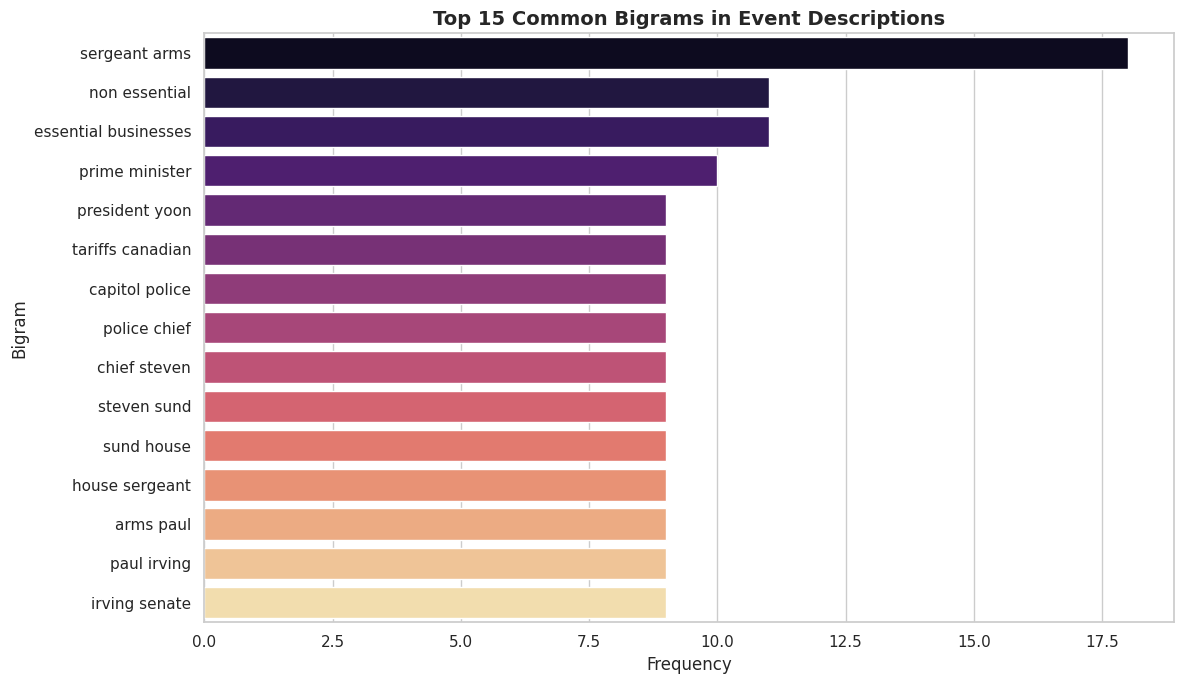

Top Bigrams:
  'sergeant arms': 18
  'non essential': 11
  'essential businesses': 11
  'prime minister': 10
  'president yoon': 9
  'tariffs canadian': 9
  'capitol police': 9
  'police chief': 9
  'chief steven': 9
  'steven sund': 9
  'sund house': 9
  'house sergeant': 9
  'arms paul': 9
  'paul irving': 9
  'irving senate': 9


In [17]:
def get_top_ngrams(corpus, n=None, top_k=10):
    """
    Returns the top k most frequent n-grams from a corpus.
    """
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# Analyze Bigrams (2-word phrases) in Target Events
events_corpus = df_questions['target_event'].tolist()
top_bigrams = get_top_ngrams(events_corpus, n=2, top_k=15)

# Visualize Bigrams
x, y = zip(*top_bigrams)
plt.figure(figsize=(12, 7))
sns.barplot(x=list(y), y=list(x), palette="magma")
plt.title("Top 15 Common Bigrams in Event Descriptions", fontsize=14, fontweight='bold')
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Bigram", fontsize=12)
plt.tight_layout()
plt.show()

print("Top Bigrams:")
for bigram, freq in top_bigrams:
    print(f"  '{bigram}': {freq}")

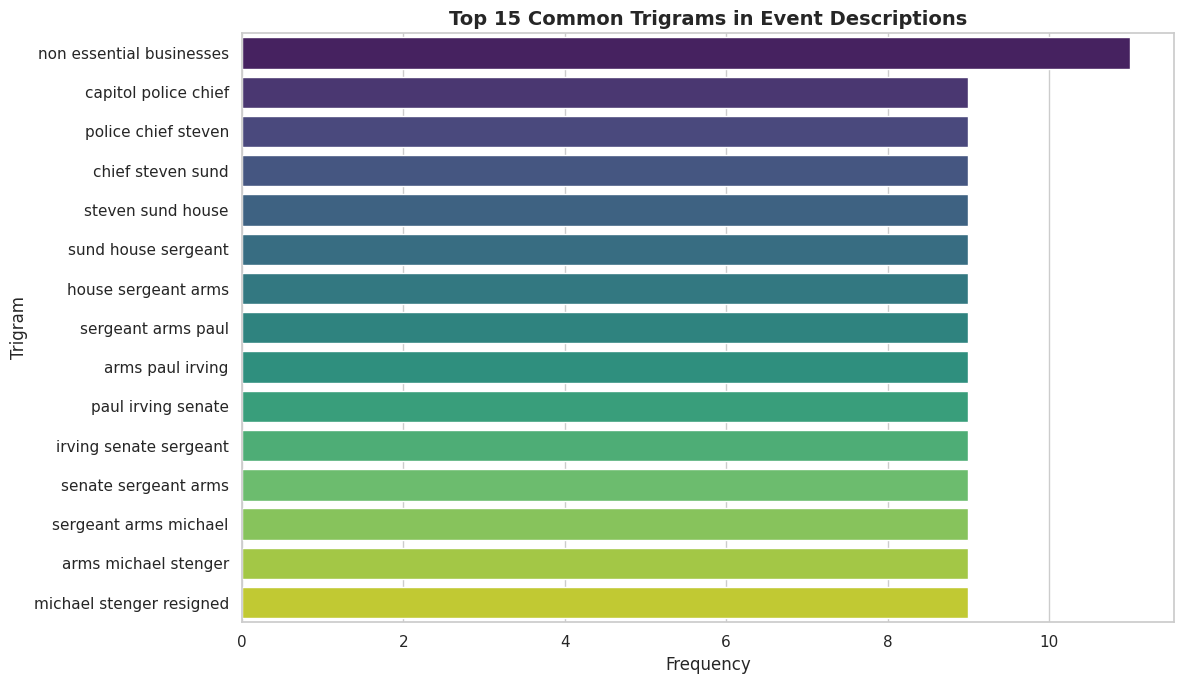


Top Trigrams:
  'non essential businesses': 11
  'capitol police chief': 9
  'police chief steven': 9
  'chief steven sund': 9
  'steven sund house': 9
  'sund house sergeant': 9
  'house sergeant arms': 9
  'sergeant arms paul': 9
  'arms paul irving': 9
  'paul irving senate': 9
  'irving senate sergeant': 9
  'senate sergeant arms': 9
  'sergeant arms michael': 9
  'arms michael stenger': 9
  'michael stenger resigned': 9


In [18]:
# Analyze Trigrams (3-word phrases)
top_trigrams = get_top_ngrams(events_corpus, n=3, top_k=15)

# Visualize Trigrams
x_tri, y_tri = zip(*top_trigrams)
plt.figure(figsize=(12, 7))
sns.barplot(x=list(y_tri), y=list(x_tri), palette="viridis")
plt.title("Top 15 Common Trigrams in Event Descriptions", fontsize=14, fontweight='bold')
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Trigram", fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop Trigrams:")
for trigram, freq in top_trigrams:
    print(f"  '{trigram}': {freq}")

## 12. Distractor Difficulty Analysis (Lexical Overlap)

Compares how similar the **correct** answer is to the context versus the **incorrect** options (distractors). This helps understand task difficulty:
- **Easy Dataset:** Correct answer has high overlap, distractors have low overlap
- **Hard Dataset:** Distractors have high overlap (trick questions), or correct answer has low overlap (requires reasoning)

In [19]:
# Initialize metrics list
distractor_analysis = []

print("Analyzing distractor difficulty...")
iterator = tqdm(df_questions.iterrows(), total=len(df_questions)) if has_tqdm else df_questions.iterrows()

for index, row in iterator:
    t_id = row['topic_id']
    if t_id not in topic_doc_map:
        continue
        
    correct_ans_keys = row['golden_answer'].split(',')  # e.g., ['A', 'B']
    all_options = ['A', 'B', 'C', 'D']
    
    # Get context
    context = topic_doc_map[t_id]
    
    # Calculate similarity for all options
    vectorizer = TfidfVectorizer(stop_words='english')
    
    sims = {}
    for opt in all_options:
        opt_text = row[f'option_{opt}']
        try:
            tfidf = vectorizer.fit_transform([opt_text, context])
            sims[opt] = cosine_similarity(tfidf[0:1], tfidf[1:2])[0][0]
        except ValueError:  # Handle empty vocabulary issues
            sims[opt] = 0.0
            
    # Average similarity for correct vs incorrect options
    correct_sims = [sims[k] for k in correct_ans_keys]
    incorrect_sims = [sims[k] for k in all_options if k not in correct_ans_keys]
    
    distractor_analysis.append({
        'avg_correct_sim': np.mean(correct_sims) if correct_sims else 0,
        'avg_incorrect_sim': np.mean(incorrect_sims) if incorrect_sims else 0,
        'diff': (np.mean(correct_sims) if correct_sims else 0) - (np.mean(incorrect_sims) if incorrect_sims else 0)
    })

df_distractor = pd.DataFrame(distractor_analysis)

print("Distractor analysis completed!")

Analyzing distractor difficulty...


  0%|          | 0/200 [00:00<?, ?it/s]

Distractor analysis completed!


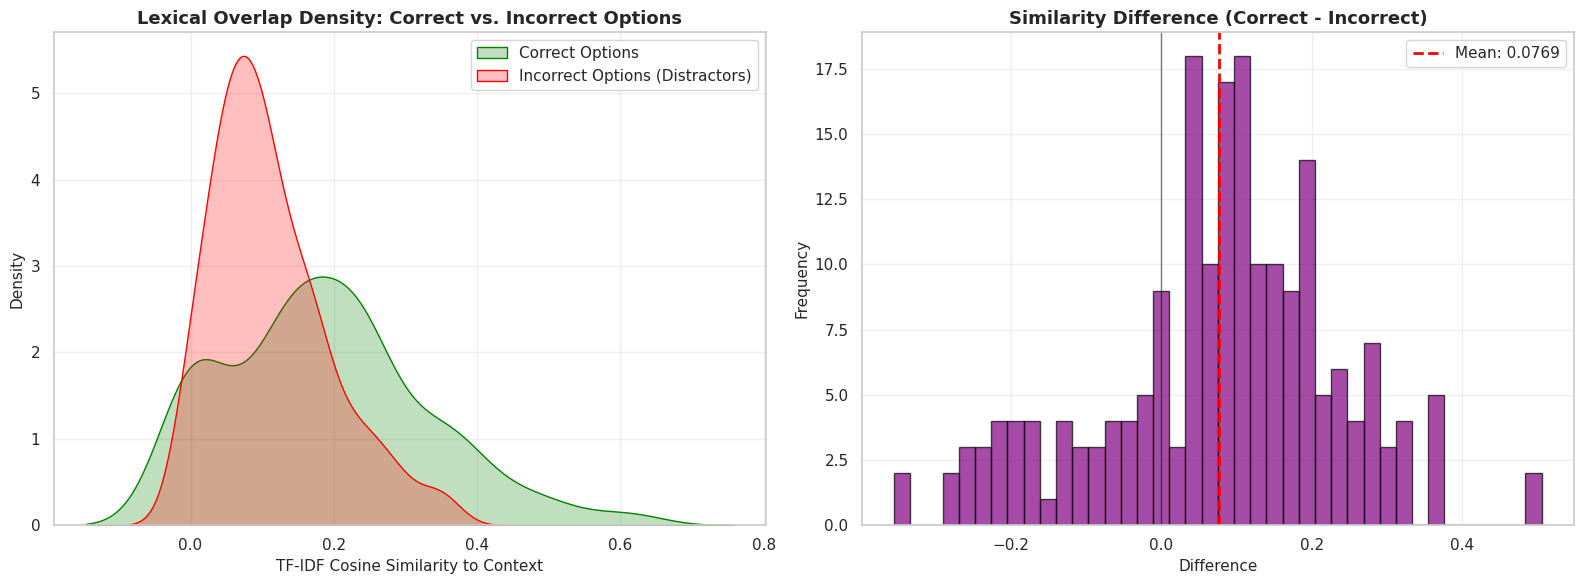


DISTRACTOR ANALYSIS
Avg Similarity (Correct Options): 0.1882
Avg Similarity (Incorrect Options): 0.1113
Average Difference: 0.0769

Interpretation:
  Correct options have significantly higher similarity - easier dataset


In [20]:
# Plotting the comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# KDE plot
sns.kdeplot(df_distractor['avg_correct_sim'], label='Correct Options', fill=True, color='green', ax=axes[0])
sns.kdeplot(df_distractor['avg_incorrect_sim'], label='Incorrect Options (Distractors)', fill=True, color='red', ax=axes[0])
axes[0].set_title("Lexical Overlap Density: Correct vs. Incorrect Options", fontsize=13, fontweight='bold')
axes[0].set_xlabel("TF-IDF Cosine Similarity to Context", fontsize=11)
axes[0].set_ylabel("Density", fontsize=11)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Difference distribution
axes[1].hist(df_distractor['diff'], bins=40, color='purple', edgecolor='black', alpha=0.7)
axes[1].axvline(df_distractor['diff'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df_distractor["diff"].mean():.4f}')
axes[1].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1].set_title("Similarity Difference (Correct - Incorrect)", fontsize=13, fontweight='bold')
axes[1].set_xlabel("Difference", fontsize=11)
axes[1].set_ylabel("Frequency", fontsize=11)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDISTRACTOR ANALYSIS")
print("=" * 60)
print(f"Avg Similarity (Correct Options): {df_distractor['avg_correct_sim'].mean():.4f}")
print(f"Avg Similarity (Incorrect Options): {df_distractor['avg_incorrect_sim'].mean():.4f}")
print(f"Average Difference: {df_distractor['diff'].mean():.4f}")
print(f"\nInterpretation:")
if df_distractor['diff'].mean() > 0.05:
    print("  Correct options have significantly higher similarity - easier dataset")
elif df_distractor['diff'].mean() < -0.05:
    print("  Distractors have higher similarity - very challenging/adversarial dataset")
else:
    print("  Similar overlap for correct and incorrect - requires deep reasoning beyond lexical matching")

## 13. Topic Visualization (t-SNE)

Visualizes how well the `topic_id` separates the events. Distinct clusters indicate semantically diverse topics.

In [21]:
# Vectorize the 'target_event' text
print("Generating TF-IDF vectors for topic visualization...")
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df_questions['target_event'])

# Dimensionality Reduction using t-SNE
print("Performing t-SNE dimensionality reduction...")
perplexity_val = min(30, len(df_questions) - 1)
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val)
X_embedded = tsne.fit_transform(X_tfidf.toarray())

# Create a DataFrame for plotting
df_tsne = pd.DataFrame(X_embedded, columns=['x', 'y'])
df_tsne['topic_id'] = df_questions['topic_id'].values

print("Visualization complete!")

Generating TF-IDF vectors for topic visualization...
Performing t-SNE dimensionality reduction...
Visualization complete!


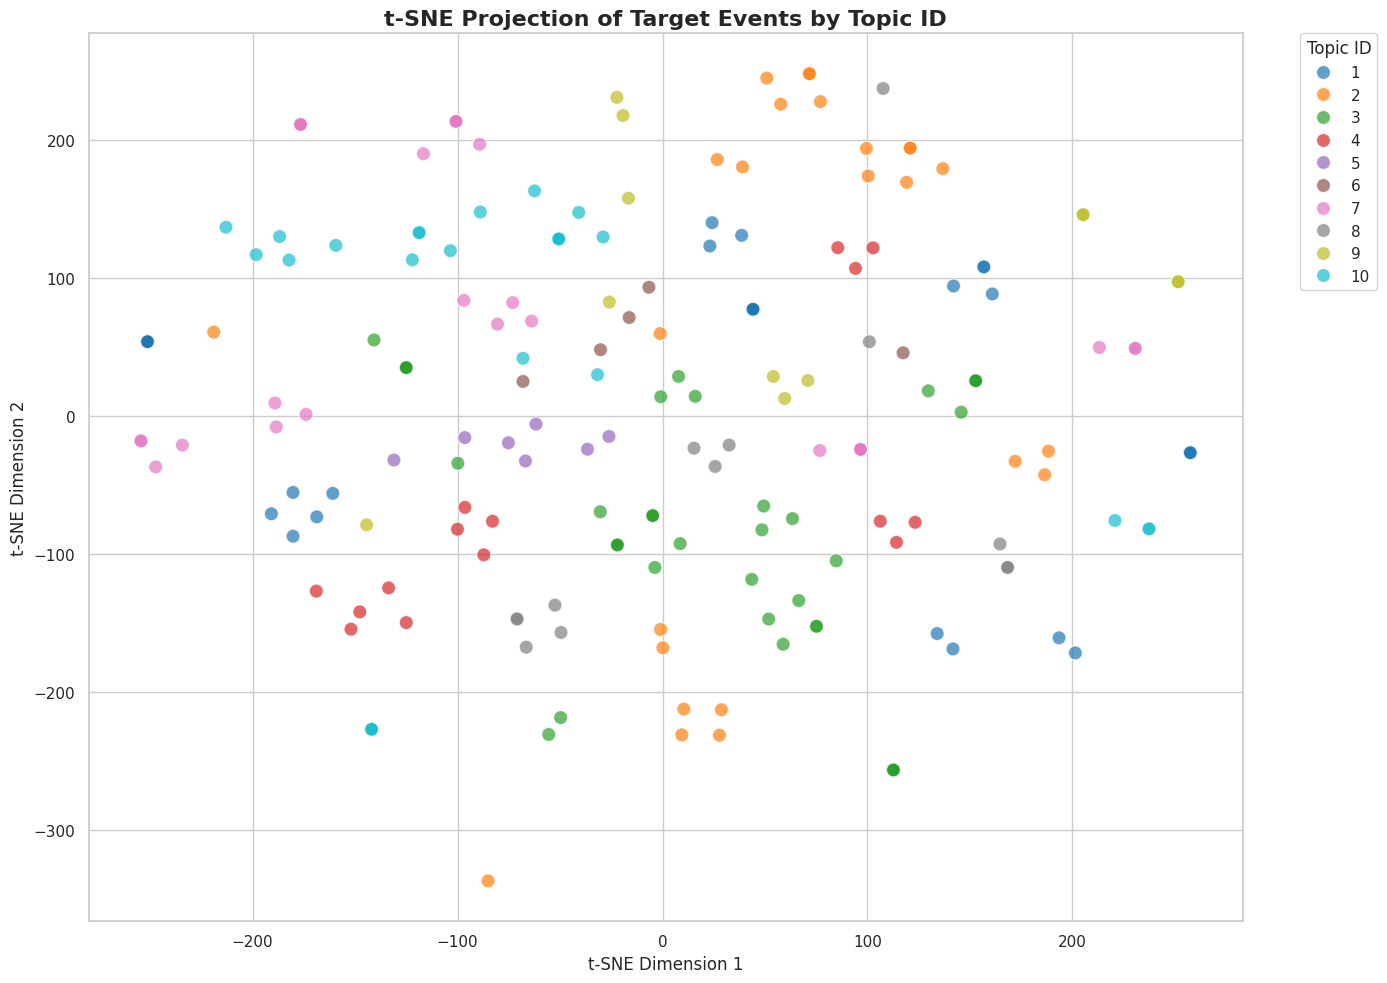


t-SNE visualization shows separation across 10 topics
Well-separated clusters indicate distinct semantic topics
Overlapping clusters suggest similar content across topics


In [22]:
# Plot
plt.figure(figsize=(14, 10))
unique_topics = df_tsne['topic_id'].nunique()

if unique_topics <= 10:
    palette = 'tab10'
elif unique_topics <= 20:
    palette = 'tab20'
else:
    palette = 'husl'

sns.scatterplot(
    data=df_tsne, 
    x='x', 
    y='y', 
    hue='topic_id', 
    palette=palette, 
    legend='full' if unique_topics <= 20 else False,
    s=100,
    alpha=0.7
)
plt.title("t-SNE Projection of Target Events by Topic ID", fontsize=16, fontweight='bold')
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)

if unique_topics <= 20:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Topic ID')
else:
    plt.text(1.02, 0.5, f'{unique_topics} topics\n(legend hidden)', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='center')

plt.tight_layout()
plt.show()

print(f"\nt-SNE visualization shows separation across {unique_topics} topics")
print("Well-separated clusters indicate distinct semantic topics")
print("Overlapping clusters suggest similar content across topics")

## 14. Named Entity Recognition (NER) Statistics

Analyzes the types and distribution of named entities in target events.

**Note:** This requires `spacy` and the `en_core_web_sm` model. Install with:
```bash
pip install spacy
python -m spacy download en_core_web_sm
```

In [23]:
# Try to load spacy
try:
    import spacy
    nlp = spacy.load("en_core_web_sm")
    print("Spacy model loaded successfully!")
    spacy_available = True
except ImportError:
    print("Spacy not installed. Please install: pip install spacy")
    spacy_available = False
except OSError:
    print("Spacy model not found. Please install: python -m spacy download en_core_web_sm")
    spacy_available = False

if spacy_available:
    all_entities = []
    entity_examples = {}
    
    print("\nExtracting named entities from target events...")
    for text in df_questions['target_event']:
        doc = nlp(text)
        for ent in doc.ents:
            all_entities.append(ent.label_)
            # Store examples
            if ent.label_ not in entity_examples:
                entity_examples[ent.label_] = []
            if len(entity_examples[ent.label_]) < 3:
                entity_examples[ent.label_].append(ent.text)
    
    # Count entity types
    entity_counts = Counter(all_entities)
    
    # Plot
    plt.figure(figsize=(14, 6))
    top_entities = dict(entity_counts.most_common(15))
    sns.barplot(x=list(top_entities.values()), y=list(top_entities.keys()), palette="coolwarm")
    plt.title("Distribution of Named Entity Types in Target Events (Top 15)", fontsize=14, fontweight='bold')
    plt.xlabel("Count", fontsize=12)
    plt.ylabel("Entity Type", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print("\nMost Common Entity Types:")
    for entity_type, count in entity_counts.most_common(10):
        examples = ", ".join(entity_examples.get(entity_type, [])[:3])
        print(f"  {entity_type}: {count} (e.g., {examples})")
else:
    print("\nSkipping NER analysis - spacy not available")

Spacy model not found. Please install: python -m spacy download en_core_web_sm

Skipping NER analysis - spacy not available


---
# Part 3: Embedding-Based Split Analysis
---

This section analyzes semantic distribution across different dataset splits (train, dev, sample) to check for distribution shifts.

## 15. Load All Data Splits

In [24]:
# Define paths for all splits
split_paths = {
    'train': 'train_data/questions.jsonl',
    'dev': 'dev_data/questions.jsonl',
    'sample': 'sample_data/questions.jsonl'
}

# Container for all data
all_data = []

# Load and label each split
print("Loading all dataset splits...")
for split_name, path in split_paths.items():
    try:
        data = load_jsonl(path)
        temp_df = pd.DataFrame(data)
        temp_df['split'] = split_name
        all_data.append(temp_df)
        print(f"  ✓ Loaded {split_name}: {len(temp_df)} rows")
    except FileNotFoundError:
        print(f"  ⚠ Warning: {split_name} file not found at {path}")

# Combine into one DataFrame
if all_data:
    df_all = pd.concat(all_data, ignore_index=True)
    print(f"\n✓ Total records across all splits: {len(df_all)}")
    print(f"  Splits available: {df_all['split'].unique().tolist()}")
else:
    print("\n⚠ No data loaded. Please check file paths.")
    df_all = pd.DataFrame()

Loading all dataset splits...
  ✓ Loaded train: 1819 rows
  ✓ Loaded dev: 400 rows
  ✓ Loaded sample: 200 rows

✓ Total records across all splits: 2419
  Splits available: ['train', 'dev', 'sample']


## 16. Generate Sentence Embeddings

Uses Sentence-BERT to convert event descriptions into dense vector representations.

**Note:** Requires `sentence-transformers`:
```bash
pip install sentence-transformers
```

In [25]:
# Try to load sentence-transformers
try:
    from sentence_transformers import SentenceTransformer
    
    # Load a lightweight, high-performance model
    model_name = 'all-MiniLM-L6-v2'
    print(f"Loading SentenceTransformer model '{model_name}'...")
    embedder = SentenceTransformer(model_name)
    print(f"✓ Model '{model_name}' loaded successfully.")
    embedder_available = True
except ImportError:
    print("sentence-transformers not installed.")
    print("Please install: pip install sentence-transformers")
    embedder_available = False
except Exception as e:
    print(f"Error loading model: {e}")
    embedder_available = False

if embedder_available and not df_all.empty:
    # Encode the target events
    print("\nGenerating embeddings for all events...")
    print("(This may take a moment depending on dataset size)")
    embeddings = embedder.encode(df_all['target_event'].tolist(), show_progress_bar=True)
    
    # Store embeddings in the DataFrame
    df_all['embedding'] = list(embeddings)
    print(f"\n✓ Generated {len(embeddings)} embeddings of dimension {embeddings.shape[1]}")
elif not embedder_available:
    print("\nSkipping embedding generation - sentence-transformers not available")
else:
    print("\nSkipping embedding generation - no data loaded")

Loading SentenceTransformer model 'all-MiniLM-L6-v2'...
✓ Model 'all-MiniLM-L6-v2' loaded successfully.

Generating embeddings for all events...
(This may take a moment depending on dataset size)


Batches:   0%|          | 0/76 [00:00<?, ?it/s]


✓ Generated 2419 embeddings of dimension 384


## 17. Visualize Split Distribution (t-SNE)

Visualizes whether the train, dev, and sample sets cover the same semantic areas.

Performing t-SNE on embeddings...
t-SNE complete! Generating visualization...


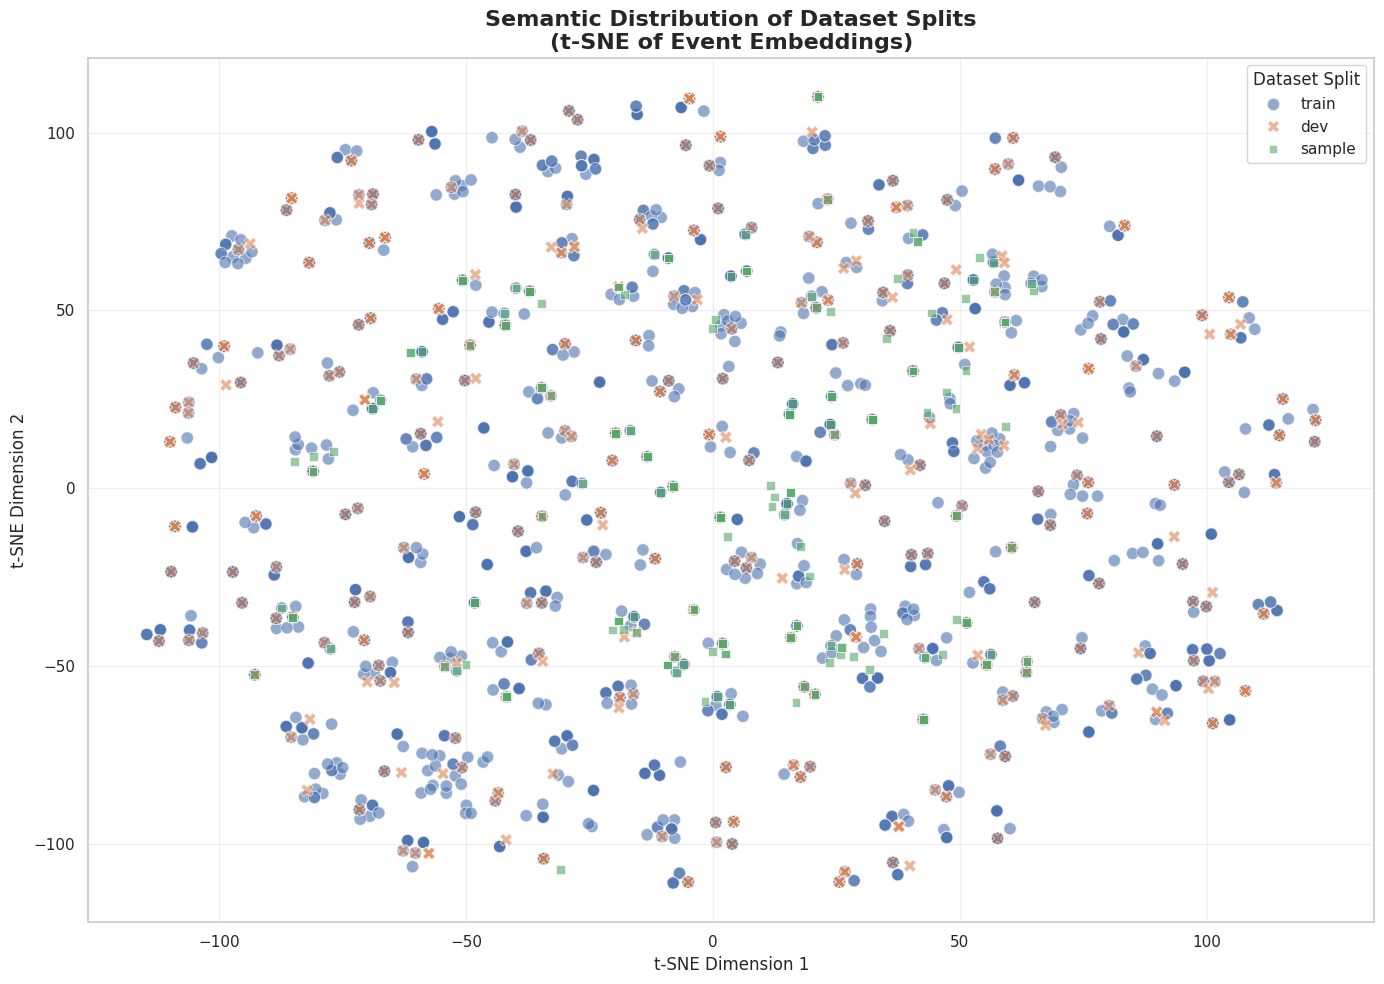


Interpretation:
  - Well-mixed colors: Splits cover similar semantic space (good)
  - Distinct color clusters: Distribution shift between splits (potential issue)


In [26]:
if embedder_available and not df_all.empty and 'embedding' in df_all.columns:
    # Convert list of arrays to a single 2D array for t-SNE
    X_embeddings = np.array(df_all['embedding'].tolist())
    
    # Reduce dimensionality to 2D
    print("Performing t-SNE on embeddings...")
    perplexity_val = min(30, len(df_all) - 1)
    tsne_model = TSNE(n_components=2, random_state=42, perplexity=perplexity_val, max_iter=1000)
    tsne_results = tsne_model.fit_transform(X_embeddings)
    
    df_all['tsne_x'] = tsne_results[:, 0]
    df_all['tsne_y'] = tsne_results[:, 1]
    
    print("t-SNE complete! Generating visualization...")
    
    # Plot
    plt.figure(figsize=(14, 10))
    sns.scatterplot(
        data=df_all,
        x='tsne_x',
        y='tsne_y',
        hue='split',
        style='split',
        alpha=0.6,
        palette='deep',
        s=80
    )
    plt.title("Semantic Distribution of Dataset Splits\n(t-SNE of Event Embeddings)", 
              fontsize=16, fontweight='bold')
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.legend(title='Dataset Split', fontsize=11, title_fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretation:")
    print("  - Well-mixed colors: Splits cover similar semantic space (good)")
    print("  - Distinct color clusters: Distribution shift between splits (potential issue)")
else:
    print("Skipping t-SNE visualization - embeddings not available")

## 18. Quantify Distribution Overlap

Calculates centroid distances between splits to mathematically quantify distribution differences.

Calculating semantic centroids for each split...

  train: 1819 samples
  dev: 400 samples
  sample: 200 samples

SEMANTIC DISTANCE BETWEEN SPLITS (Euclidean Distance)
  train ↔ dev: 0.0505
  train ↔ sample: 0.1880
  dev ↔ sample: 0.1806


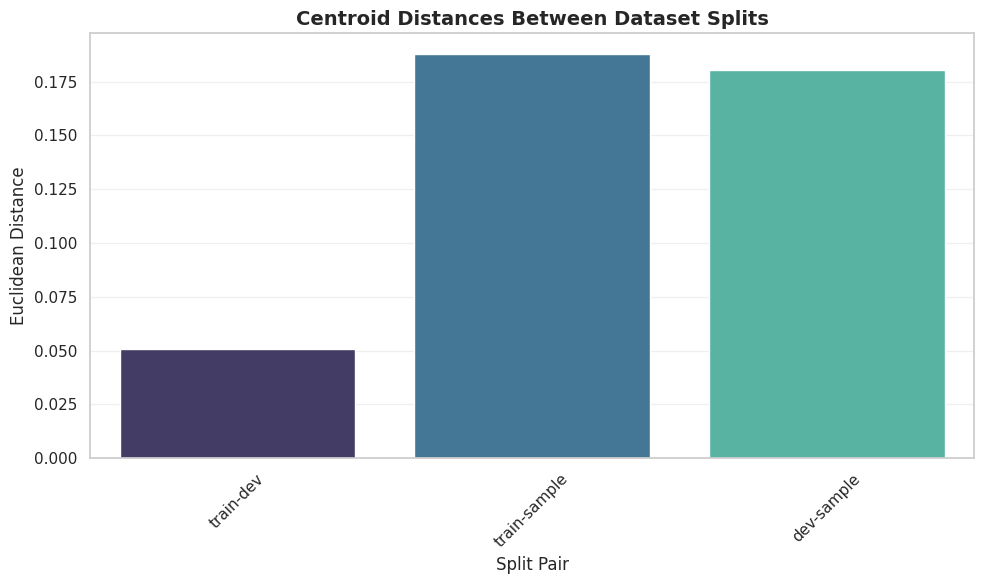


Interpretation:
  Average distance: 0.1397
  ✓ Low distance - splits are semantically similar


In [27]:
if embedder_available and not df_all.empty and 'embedding' in df_all.columns:
    splits = df_all['split'].unique()
    centroids = {}
    
    # Calculate centroid (mean embedding) for each split
    print("Calculating semantic centroids for each split...\n")
    for split in splits:
        split_embeddings = np.array(df_all[df_all['split'] == split]['embedding'].tolist())
        centroids[split] = np.mean(split_embeddings, axis=0)
        print(f"  {split}: {len(split_embeddings)} samples")
    
    # Calculate distances between centroids
    print("\n" + "=" * 70)
    print("SEMANTIC DISTANCE BETWEEN SPLITS (Euclidean Distance)")
    print("=" * 70)
    
    base_split = 'train' if 'train' in splits else splits[0]
    
    distances = {}
    for i, split1 in enumerate(splits):
        for split2 in splits[i+1:]:
            dist = euclidean_distances([centroids[split1]], [centroids[split2]])[0][0]
            distances[f"{split1}-{split2}"] = dist
            print(f"  {split1} ↔ {split2}: {dist:.4f}")
    
    # Visualize distances
    if len(distances) > 0:
        plt.figure(figsize=(10, 6))
        pairs = list(distances.keys())
        dists = list(distances.values())
        
        sns.barplot(x=pairs, y=dists, palette='mako')
        plt.title("Centroid Distances Between Dataset Splits", fontsize=14, fontweight='bold')
        plt.xlabel("Split Pair", fontsize=12)
        plt.ylabel("Euclidean Distance", fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("\nInterpretation:")
        avg_dist = np.mean(list(distances.values()))
        print(f"  Average distance: {avg_dist:.4f}")
        if avg_dist < 5:
            print("  ✓ Low distance - splits are semantically similar")
        elif avg_dist < 10:
            print("  ⚠ Moderate distance - some distribution differences")
        else:
            print("  ⚠ High distance - significant distribution shift between splits")
else:
    print("Skipping distance calculation - embeddings not available")

## 19. Export Analysis Results

In [28]:
# Save the enriched questions dataframe with computed features
output_file = f'{DATASET}_analysis_results.csv'
df_questions.to_csv(output_file, index=False)
print(f"✓ Analysis results saved to: {output_file}")

# Save summary statistics
summary_stats = {
    'dataset': DATASET,
    'total_questions': len(df_questions),
    'total_topics': df_questions['topic_id'].nunique(),
    'total_documents': len(all_doc_lengths),
    'avg_event_length': df_questions['event_word_count'].mean(),
    'avg_option_length': df_questions['avg_option_len'].mean(),
    'avg_doc_length': np.mean(all_doc_lengths),
    'avg_docs_per_topic': np.mean(doc_counts_per_topic),
    'mean_context_similarity': df_questions['context_similarity'].mean(),
    'mean_event_options_similarity': df_questions['event_options_similarity'].mean(),
}

# Add distractor analysis if available
if 'df_distractor' in locals() and not df_distractor.empty:
    summary_stats['avg_correct_sim'] = df_distractor['avg_correct_sim'].mean()
    summary_stats['avg_incorrect_sim'] = df_distractor['avg_incorrect_sim'].mean()
    summary_stats['distractor_diff'] = df_distractor['diff'].mean()

summary_df = pd.DataFrame([summary_stats])
summary_file = f'{DATASET}_summary_stats.csv'
summary_df.to_csv(summary_file, index=False)
print(f"✓ Summary statistics saved to: {summary_file}")

# Save all splits analysis if available
if embedder_available and not df_all.empty:
    all_splits_file = 'all_splits_with_embeddings.csv'
    # Remove embedding column for CSV (too large)
    df_all_export = df_all.drop(columns=['embedding'], errors='ignore')
    df_all_export.to_csv(all_splits_file, index=False)
    print(f"✓ All splits data saved to: {all_splits_file}")

✓ Analysis results saved to: sample_data_analysis_results.csv
✓ Summary statistics saved to: sample_data_summary_stats.csv
✓ All splits data saved to: all_splits_with_embeddings.csv


## 20. Optional: Compare Across Datasets

Run this cell after analyzing all three datasets (sample, train, dev) to compare them.

In [29]:
# This cell can be used to load and compare results from all datasets
import glob

summary_files = glob.glob('*_summary_stats.csv')
if len(summary_files) > 1:
    all_summaries = pd.concat([pd.read_csv(f) for f in summary_files], ignore_index=True)
    
    print("\n" + "="*80)
    print("CROSS-DATASET COMPARISON")
    print("="*80)
    display(all_summaries)
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    metrics = [
        ('total_questions', 'Total Questions'),
        ('avg_docs_per_topic', 'Avg Docs per Topic'),
        ('mean_context_similarity', 'Mean Context Similarity'),
        ('avg_event_length', 'Avg Event Length (words)')
    ]
    
    for idx, (metric, title) in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        if metric in all_summaries.columns:
            all_summaries.plot(x='dataset', y=metric, kind='bar', ax=ax, legend=False, color='steelblue')
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.set_xlabel('Dataset')
            ax.set_ylabel(metric.replace('_', ' ').title())
            ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Only one dataset analyzed so far. Run the notebook with different DATASET values to compare.")

Only one dataset analyzed so far. Run the notebook with different DATASET values to compare.
